In [4]:
import os
import sys
import shutil
import argparse
import math
import IPython 
from PIL import Image
from enum import Enum
from typing import Callable, List, Optional, Tuple, Union
from functools import partial

import h5py
import logging
import torch
import torch.nn as nn
import torchio as tio
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import skimage
from scipy import sparse
import scipy.io as sio
import matplotlib.pyplot as plt 
import torchxrayvision as xrv
import nibabel as nib
from typing import Any, Dict, Optional
from collections import OrderedDict
from monai.losses.dice import DiceLoss, DiceCELoss

from torchmetrics import Metric, MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from torchmetrics.classification import (MultilabelAUROC, MultilabelF1Score, MultilabelAccuracy, MulticlassF1Score, 
                                        MulticlassAccuracy, MulticlassAUROC, Accuracy, BinaryF1Score, BinaryAUROC,
                                        JaccardIndex, MulticlassJaccardIndex, Dice, BinaryAUROC)

from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
import dinov2.distributed as distributed
from dinov2.models.unet import UNet
from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data.datasets import NIHChestXray, MC, Shenzhen, SARSCoV2CT, BTCV, BTCVSlice, AMOS, MSDHeart
from dinov2.data.datasets.medical_dataset import MedicalVisionDataset
from dinov2.data.loaders import make_data_loader
from dinov2.data.transforms import (make_segmentation_train_transforms, make_classification_eval_transform, make_segmentation_eval_transforms,
                                    make_classification_train_transform)
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import (is_padded_matrix, ModelWithIntermediateLayers, ModelWithNormalize, evaluate, extract_features, collate_fn_3d,
                               make_datasets, make_data_loaders)
from dinov2.eval.classification.utils import LinearClassifier, create_linear_input, setup_linear_classifiers, AllClassifiers
from dinov2.eval.metrics import build_segmentation_metrics, MetricAveraging, MetricType
from dinov2.eval.segmentation.utils import LinearDecoder, setup_decoders, DINOV2Encoder
from dinov2.utils import show_image_from_tensor

In [51]:
class _Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

    @property
    def length(self) -> int:
        split_lengths = {
            _Split.TRAIN: 11350,
            _Split.VAL: 2770,
            _Split.TEST: 7004,
        }
        return split_lengths[self]

class AMOS(MedicalVisionDataset):
    Split = _Split

    def __init__(
        self,
        *,
        split: "AMOS.Split",
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(split, root, transforms, transform, target_transform)

        self.images = np.sort(np.array(os.listdir(self._split_dir)))

        self._labels_path = f"{os.sep}".join(self._split_dir.split(f"{os.sep}")[:-1]) + os.sep + "labels"
        self.labels = np.sort(np.array(os.listdir(self._labels_path)))

        labels_in = np.isin(self.labels, self.images)
        self.labels = self.labels[labels_in]
    
        self.class_id_mapping = pd.DataFrame([i for i in range(16)],
                                    index=["background",
                                            "spleen",
                                            "right kidney",
                                            "left kidney",
                                            "gall bladder",
                                            "esophagus",
                                            "liver",
                                            "stomach",
                                            "aorta",
                                            "postcava",
                                            "pancreas",
                                            "right adrenal gland",
                                            "left adrenal gland",
                                            "duodenum",
                                            "bladder",
                                            "prostate/uterus"],
                                    columns=["class_id"])
        self.class_names = np.array(self.class_id_mapping.index)

    def get_num_classes(self) -> int:
        return len(self.class_names)

    def is_3d(self) -> bool:
        return False

    def get_image_data(self, index: int) -> np.ndarray:
        image_path = self._split_dir + os.sep + self.images[index]
        image = np.load(image_path)
        image = np.stack((image,)*3, axis=0)
        image = torch.tensor(image).float()

        image = torch.clamp(image, min=-1024, max=600)
        return image
    
    def get_target(self, index: int) -> Tuple[np.ndarray, torch.Tensor, None]:        
        label_path = self._labels_path + os.sep + self.labels[index]
        label = np.load(label_path)
        label = torch.from_numpy(label).unsqueeze(0)

        return label
    
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int):

        seed = np.random.randint(2147483647) # make a seed with numpy generator 

        image = self.get_image_data(index)
        target = self.get_target(index)

        if self.transform is not None:
            np.random.seed(seed), torch.manual_seed(seed) 
            image = self.transform(image)

        if self.target_transform is not None and target is not None:
            np.random.seed(seed), torch.manual_seed(seed) 
            target = self.target_transform(target)

        # Remove channel dim in target
        target = target.squeeze()

        return image, target

In [52]:
class _Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

    @property
    def length(self) -> int:
        split_lengths = {
            _Split.TRAIN: 11350,
            _Split.VAL: 2770,
            _Split.TEST: 7004,
        }
        return split_lengths[self]
d = AMOS(split=_Split.TRAIN, root="/mnt/z/data/AMOS")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/z/data/AMOS/train'

/mnt/z/data/MSDHeart/train/la_005_010.npy
/mnt/z/data/MSDHeart/labels/la_005_010.npy


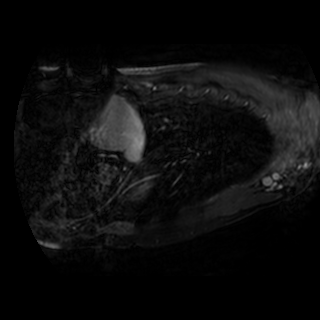

None


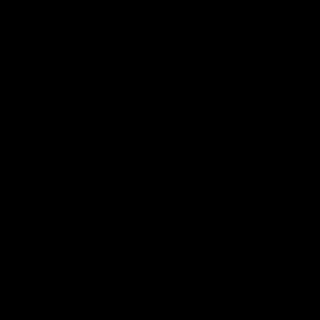

None


In [50]:
i, t = d[10]
# for i, t in d:
print(show_image_from_tensor(i // 8))
print(show_image_from_tensor(t.unsqueeze(0) * 100))
    # break

In [ ]:
]
# for i, t in d:
print(show_image_from_tensor(i // 8))
print(show_image_from_tensor(t.unsqueeze(0)))
    # break

In [ ]:
import torchmetrics

In [ ]:
data_dir = "/mnt/z/data/amos22/"
train_data_path = data_dir + "train/"
train_data = os.listdir(train_data_path)

val_data_path = data_dir + "val/"
val_data = os.listdir(val_data_path)

test_data_path = data_dir + "test/"
test_data = os.listdir(test_data_path)

label_data_path = data_dir + "labels/"
label_data = os.listdir(label_data_path)

for label in label_data:
    if label not in train_data or label not in val_data or label not in test_data:
        os.remove(label_data_path + label)

In [ ]:
data_dir = "/mnt/z/data/amos22/"
images_data_path = data_dir + "images/"
images_data = os.listdir(images_data_path)

train_data_path = data_dir + "train"
val_data_path = data_dir + "val"
test_data_path = data_dir + "test"
label_data_path = data_dir + "labels"

# os.makedirs(train_data_path, exist_ok=True)
# train_images = np.arange(0, 300, 300/80).round().astype("int")
# os.makedirs(val_data_path, exist_ok=True)
# val_images = np.arange(0, 220, 220/20).round().astype("int")
# os.makedirs(test_data_path, exist_ok=True)
# test_images = np.arange(0, 200, 200/50).round().astype("int")

# to_remove = []
# for indx in train_images:
#     image = images_data[indx]
#     image_path = images_data_path + image
#     shutil.move(image_path, train_data_path)
#     to_remove.append(image)
# for img in to_remove: images_data.remove(img)

# to_remove = []
# for indx in val_images:
#     image = images_data[indx]
#     image_path = images_data_path + image
#     shutil.move(image_path, val_data_path)
#     to_remove.append(image)
# for img in to_remove: images_data.remove(img)

# to_remove = []
# for indx in test_images:
#     image = images_data[indx]
#     image_path = images_data_path + image
#     shutil.move(image_path, test_data_path)
#     to_remove.append(image)
# for img in to_remove: images_data.remove(img)

train_data = os.listdir(train_data_path)
val_data = os.listdir(val_data_path)
test_data = os.listdir(test_data_path)
label_data = os.listdir(label_data_path)

for scan in label_data:
    if scan not in train_data and scan not in val_data and scan not in test_data:
        os.remove(label_data_path + os.sep + scan)

for scan in train_data:
    nifit_scan = nib.load(train_data_path + os.sep + scan)
    array = nifit_scan.get_fdata()
    array = array.transpose(2, 0, 1)
    scan_name = scan.split(".")[0]

    for i, slice in enumerate(array):
        num = str(i).zfill(3)
        np.save(train_data_path + os.sep + scan_name  + f"_{num}.npy", slice)
    os.remove(train_data_path + os.sep + scan)

for scan in val_data:
    nifit_scan = nib.load(val_data_path + os.sep + scan)
    array = nifit_scan.get_fdata()
    array = array.transpose(2, 0, 1)
    
    scan_name = scan.split(".")[0]
    for i, slice in enumerate(array):
        num = str(i).zfill(3)
        np.save(val_data_path + os.sep + scan_name  + f"_{num}.npy", slice)
    os.remove(val_data_path + os.sep + scan)

for scan in test_data:
    nifit_scan = nib.load(test_data_path + os.sep + scan)
    array = nifit_scan.get_fdata()
    array = array.transpose(2, 0, 1)
    
    scan_name = scan.split(".")[0]
    for i, slice in enumerate(array):
        num = str(i).zfill(3)
        np.save(test_data_path + os.sep + scan_name  + f"_{num}.npy", slice)
    os.remove(test_data_path + os.sep + scan)

for scan in label_data:
    nifit_scan = nib.load(label_data_path + os.sep + scan)
    array = nifit_scan.get_fdata()
    array = array.transpose(2, 0, 1)
    scan_name = scan.split(".")[0]

    for i, slice in enumerate(array):
        num = str(i).zfill(3)
        np.save(label_data_path + os.sep + scan_name  + f"_{num}.npy", slice)
    os.remove(label_data_path + os.sep + scan)

In [ ]:
from monai.networks.nets import SwinUNETR

In [ ]:
# args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH', val_dataset_str='NIHChestXray:split=VAL:root=/mnt/d/data/NIH', test_dataset_str='NIHChestXray:split=TEST:root=/mnt/d/data/NIH', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
# args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='MC:split=TRAIN:root=/mnt/z/data/MC', val_dataset_str='MC:split=VAL:root=/mnt/z/data/MC', test_dataset_str='MC:split=TEST:root=/mnt/z/data/MC', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
args = argparse.Namespace(backbone="dinov2", config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='BTCV:split=TRAIN:root=/mnt/z/data/BTCV', test_dataset_str='BTCV:split=VAL:root=/mnt/z/data/BTCV', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
model, autocast_dtype = setup_and_build_model(args)
autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=autocast_dtype)
# feature_model_with_inter = ModelWithIntermediateLayers(model, 4, autocast_ctx, is_3d=False)
# model = ModelWithNormalize(model)

In [ ]:
from transformers import SamModel, SamProcessor
from transformers import (
    SamVisionConfig,
    SamPromptEncoderConfig,
    SamMaskDecoderConfig,
    SamModel,
    SamConfig,
)

config = SamConfig(SamVisionConfig(image_size=224))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-large", config=config, ignore_mismatched_sizes=True).to(device)

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
from dinov2.eval.utils import bitfit
model = bitfit(model)

In [ ]:
print_trainable_parameters(model)

In [ ]:
def count_total_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [ ]:
count_total_parameters(model)

In [ ]:
train_image_transform, train_target_transform = make_segmentation_train_transforms(resize_size=224)
eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms(resize_size=224)
images = BTCVSlice(root="/mnt/z/data/BTCVSlice/", split=_Split.TRAIN, transform=train_image_transform, target_transform=train_target_transform)

In [ ]:
model.vision_encoder

In [ ]:
for i, t in train_dataset:
    print(i.shape)
    l = model.get_image_embeddings(i[0].unsqueeze(0))
    print(l.shape)
    print(np.unique(t))
    print(t.max())
    show_image_from_tensor(t[6].unsqueeze(0) * 50 )
    print(images.get_num_classes())
    break

In [ ]:
train_image_transform, train_target_transform = make_segmentation_train_transforms(resize_size=224)
eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms(resize_size=224)
# train_image_transform = make_classification_train_transform()
# eval_image_transform = make_classification_eval_transform()

# train_target_transform = eval_target_transform = None

# val_dataset_str = args.val_dataset_str
val_dataset_str = None

train_dataset, val_dataset, test_dataset = make_datasets(train_dataset_str=args.train_dataset_str, val_dataset_str=val_dataset_str,
                                                        test_dataset_str=args.test_dataset_str, train_transform=train_image_transform,
                                                        eval_transform=eval_image_transform, train_target_transform=train_target_transform,
                                                        eval_target_transform=eval_target_transform)
is_3d = test_dataset.is_3d()
collate_fn=collate_fn_3d if is_3d else None
start_iter=1
sampler_type = SamplerType.INFINITE
# sampler_type = None
seed = 0
batch_size = 1
num_workers = 0
train_data_loader, val_data_loader, test_data_loader = make_data_loaders(train_dataset=train_dataset, test_dataset=test_dataset,
                                                                        val_dataset=val_dataset, sampler_type=sampler_type, seed=seed,
                                                                        start_iter=start_iter, batch_size=batch_size, num_workers=num_workers,
                                                                        collate_fn=collate_fn)


# train_data_loader = make_data_loader(
#     dataset=train_dataset,
#     batch_size=2,
#     num_workers=0,
#     shuffle=True,
#     seed=0,
#     sampler_type=sampler_type,
#     sampler_advance=0,
#     drop_last=False,
#     persistent_workers=False,
#     collate_fn=collate_fn_3d if is_3d else None
# )



# train_data_loader = make_data_loader(
#     dataset=images,
#     batch_size=4,
#     num_workers=0,
#     shuffle=True,
#     seed=0,
#     sampler_type=sampler_type,
#     sampler_advance=0,
#     drop_last=False,
#     persistent_workers=False,
#     collate_fn=collate_fn_3d if is_3d else None
# )

# val_data_loader = make_data_loader(
#     dataset=val_dataset,
#     batch_size=4,
#     num_workers=0,
#     shuffle=True,
#     seed=0,
#     sampler_type=None,
#     sampler_advance=0,
#     drop_last=False,
#     persistent_workers=False,
#     collate_fn=collate_fn_3d if is_3d else None
# )

In [ ]:
class Model3DWrapper(nn.Module):
    def __init__(self, model, per_slice=False) -> None:
        super().__init__()
        self.model = model
        self.per_slice = per_slice

    def forward(self, x):
        batch_outputs = []
        for slices in x: 
            if self.per_slice:
                batch_outputs.append(
                    torch.stack([self.model(slice_) for slice_ in slices], dim=0).squeeze()
                )
            else:
                batch_outputs.append(
                    self.model(slices)
                )
        return batch_outputs

In [ ]:
labels = train_dataset.class_names
num_of_classes = train_dataset.get_num_classes()

In [ ]:
m = build_segmentation_metrics(MetricType.SEGMENTATION_METRICS.accuracy_averaging, num_labels=7, labels=labels.tolist())
m = m.to("cuda")

In [ ]:
img1, lbl1 = test_dataset[0]
slice1, slice1lbl = img1[130].cuda(non_blocking=True), lbl1[130].cuda(non_blocking=True) 

In [ ]:
slice1 = slice1.unsqueeze(0)
slice1lbl = slice1lbl.unsqueeze(0)

In [ ]:
slice1 = slice1.type(torch.float16)

In [ ]:
feature_model = DINOV2Encoder(model, autocast_ctx=autocast_ctx, n_last_blocks=1, is_3d=False).cuda()
decoder = LinearDecoder(in_channels=model.embed_dim, num_classes=7, image_size=224).cuda()
# decoder = Model3DWrapper(decoder, per_slice=True)
optimizer = torch.optim.SGD(decoder.parameters(), lr=3.5e-4, momentum=0.9, weight_decay=0)
loss_function = nn.CrossEntropyLoss()
for i in range(1000):
    o1 = feature_model(slice1)
    o2 = decoder(o1)

    
    o2 = o2.type(torch.float16)
    print(slice1lbl.dtype)
    loss = loss_function(o2, slice1lbl)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        # o2 = torch.argmax(o2, dim=1)
        print(loss)
        # print(m(o2, slice1lbl))

In [ ]:
from dinov2.logging import MetricLogger
metric_logger = MetricLogger(delimiter="  ")

feature_model = DINOV2Encoder(model, autocast_ctx=autocast_ctx, n_last_blocks=1, is_3d=True).cuda()
decoder = Model3DWrapper(LinearDecoder(in_channels=model.embed_dim, num_classes=14, image_size=224).cuda(), per_slice=True)
        
for samples, targets in train_data_loader:

    samples = samples.cuda(non_blocking=True)

    o1 = feature_model(samples)
    # o2 = decoder(o1)

    # o2 = torch.cat(o2, dim=0).cuda()
    # targets = torch.cat(targets, dim=0).cuda()
    # preds = o2.argmax(dim=1)
    # targets = targets.type(torch.int64)

    # print(o2.shape)
    # print(targets.shape)

    # z = {
    #     "preds": preds[50:80],
    #     "target": targets[50:80],
    # }

    # print(m.update(**z))
    # print(m)
    # print(m.compute())

    break 
    # print(t.shape)
    # print(t.dtype)

In [ ]:
preds[0]

In [ ]:
embed_dim = model.embed_dim

In [ ]:
class UNetDecoderUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim=1024) -> None:
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.skip_conv = nn.Sequential(
            nn.Conv2d(embed_dim, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )        

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        x2 = self.skip_conv(x2)
        scale_factor = (x1.size()[2] / x2.size()[2])
        x2 = nn.Upsample(scale_factor=scale_factor, mode="bilinear", align_corners=True)(x2)
        x = torch.concat([x1, x2], dim=1)
        return self.conv(x)

In [ ]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, image_size=224):
        super(UNetDecoder, self).__init__()
        self.embed_dim = in_channels
        self.image_size = image_size
        self.out_channels = out_channels
        self.up1 = UNetDecoderUpBlock(in_channels=in_channels, out_channels=in_channels//2, embed_dim=embed_dim)
        self.up2 = UNetDecoderUpBlock(in_channels=in_channels//2, out_channels=in_channels//4, embed_dim=embed_dim)
        self.up3 = UNetDecoderUpBlock(in_channels=in_channels//4, out_channels=in_channels//8, embed_dim=embed_dim)
        self.up4 = UNetDecoderUpBlock(in_channels=in_channels//8, out_channels=out_channels, embed_dim=embed_dim)

    def forward(self, x):

        h = w = self.image_size//14

        skip1 = x[3].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip2 = x[2].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip3 = x[1].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip4 = x[0].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        x1    = x[3].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        
        x2 = self.up1(x1, skip1)
        x3 = self.up2(x2, skip2)
        x4 = self.up3(x3, skip3)
        x5 = self.up4(x4, skip4)

        return x5

In [ ]:
for i, t in train_data_loader:
    print(i.shape)
    continue

In [ ]:
feature_model = DINOV2Encoder(model, autocast_ctx=autocast_ctx, n_last_blocks=1, is_3d=True).cuda()
decoder = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True, image_size=224).cuda()
# feature_model.eval()
# decoder = UNetDecoder(in_channels=model.embed_dim, out_channels=3).cuda()
# feature_model_with_inter = ModelWithIntermediateLayers(model, 1, autocast_ctx, is_3d=False)
# feature_model_with_inter.eval()
for i, t in train_data_loader:
    i = i.cuda()
    print(i.shape)
    embeddings = feature_model(i)
    output = decoder(embeddings)
    output = torch.stack(output, dim=0)
    t = torch.stack(t, dim=0)
    # print(t.unsqueeze(1).shape)
    print(output.shape)
    print(t.shape)
    # break

In [ ]:
img = test_dataset.get_image_data(0)
lbl = test_dataset.get_target(0)

In [ ]:
class DINOV2Encoder(torch.nn.Module):
    def __init__(self, encoder, autocast_ctx, is_3d=False) -> None:
        super(DINOV2Encoder, self).__init__()
        self.encoder = encoder
        self.encoder.eval()
        self.autocast_ctx = autocast_ctx
        self.is_3d = is_3d
    
    def forward_3d(self, x):
        batch_features = [] 
        for batch_scans in x: # calculate the features for every scan in all scans of the batch
            scans = []
            for scan in batch_scans:
                if not is_zero_matrix(scan): scans.append(self.forward_(scan.unsqueeze(0)))
            batch_features.append(scans)
        return batch_features

    def forward_(self, x):
        with torch.no_grad():
            with self.autocast_ctx():
                features = self.encoder.forward_features(x)['x_norm_patchtokens']
        return features

    def forward(self, x):
        if is_3d:
            return self.forward_3d(x)
        return self.forward_(x)

In [ ]:
for i, t in test_dataset:
    show_image_from_tensor(i[0] * 100)
    show_image_from_tensor(i[1] * 100)
    show_image_from_tensor(i[2] * 100)


In [ ]:
def save_test_results(feature_model, decoder, dataset):
    for i, (img, _) in enumerate(dataset):

        img_name = test_dataset.images[i]
        _, affine_matrix = test_dataset.get_image_data(i, return_affine_matrix=True)

        img = img.cuda(non_blocking=True) 

        features = feature_model(img.unsqueeze(0))
        output = decoder(features, up_size=512)[0]
        output = output.argmax(dim=1)

        nifti_img = nib.Nifti1Image(output
                                    .cpu()
                                    .numpy()
                                    .astype(np.uint8)
                                    .transpose(1, 2, 0), affine_matrix)    
        file_output_dir = test_results_path + os.sep + img_name + ".gz"

        # Save the NIfTI image
        nib.save(nifti_img, file_output_dir)

In [ ]:
f = DINOV2Encoder(model, autocast_ctx=autocast_ctx, is_3d=True).cuda()
ld = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True).cuda()
save_test_results(f, ld, test_dataset)

In [ ]:
f = DINOV2Encoder(model, autocast_ctx=autocast_ctx, is_3d=True).cuda()
ld = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True).cuda()
optimizer = torch.optim.SGD(ld.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)

for i, t in train_data_loader:
    i = i.cuda(non_blocking=True) 

    features = f(i)
    output = ld(features)
    
    output = torch.cat(output, dim=0)
    t = torch.cat(t, dim=0)

    loss = nn.CrossEntropyLoss()(output, t.cuda(non_blocking=True).type(torch.int64))

    optimizer.zero_grad()
    loss.backward()

    # step
    optimizer.step()
    # labels = t.view(-1, t.shape[-1], t.shape[-1])
    # losses = nn.CrossEntropyLoss()(output.view(-1, 14, labels.shape[-1], labels.shape[-1]), labels)
        
    print(loss)

In [ ]:

ld = LinearDecoder(in_channels=embed_dim, num_classes=3, is_3d=True)
ld = ld.cuda()

o = ld(features)
print(len(o))
print(o.shape)
o = torch.stack([torch.nn.functional.interpolate(batch_output, size=448, mode="bilinear", align_corners=False)
                for batch_output in torch.unbind(o, dim=0)], dim=0)
# ou = torch.nn.functional.interpolate(o[0], size=448, mode="bilinear", align_corners=False)
print(o.shape)

In [ ]:
for i, t in train_data_loader:
    i = i.cuda()
    i = feature_model(i)
    print(len(i))
    print(len(i[0]))
    print(len(i[0][0]))
    print(len(i[0][0][0]))
    print(len(i[0][0][0][0]))
    break

In [ ]:
class LinearDecoder(torch.nn.Module):
    """Linear decoder head"""
    DECODER_TYPE = "linear"

    def __init__(self, in_channels, tokenW=32, tokenH=32, num_classes=3):
        super().__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_classes, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        print(embeddings.shape)
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        print(embeddings.shape)
        embeddings = embeddings.permute(0,3,1,2)
        print(embeddings.shape)

        return self.decoder(embeddings)

In [ ]:
d = LinearDecoder(384, num_classes=2).cuda()

In [ ]:
for i, t in train_dataset:
    i = i.cuda().unsqueeze(0)
    a = model(i)
    b = model.forward_features(i)['x_norm_patchtokens']
    z = d(b)
    print(z.shape)
    break

In [ ]:
concated = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

In [ ]:
len(concated)

In [ ]:
concated.get_num_classes()

In [ ]:
for i, t in concated:
    print(i)

In [ ]:
data_dir = "/mnt/d/data/NIH/"
train_val = pd.read_csv(data_dir + os.sep + "train_val_list.txt", names=["Image Index"])
val_list = [i for i in range(len(train_val)-10_002, len(train_val))]
val_set = train_val.iloc[val_list]
train_set = train_val.drop(val_list)

train_dir = data_dir + os.sep + "train"
val_dir = data_dir + os.sep + "val"
for image in val_set["Image Index"]:
    source = train_dir + os.sep + image
    dest = val_dir + os.sep + image
    shutil.move(source, dest)

val_set.to_csv(data_dir + os.sep + "val_list.txt", index=False, header=False)
train_set.to_csv(data_dir + os.sep + "train_list.txt", index=False, header=False)

In [ ]:
class LinearDecoder(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearDecoder, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_labels, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.decoder(embeddings)

In [ ]:
decoder = LinearDecoder(384, num_labels=3).cuda()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.0005, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 69, eta_min=0)

In [ ]:
class MetricAveraging(Enum):
    MEAN_ACCURACY = "micro"
    MEAN_PER_CLASS_ACCURACY = "macro"
    MULTILABEL_ACCURACY = "macro"
    MULTILABEL_AUROC = "macro"
    MULTILABEL_JACCARD = "macro"
    PER_CLASS_ACCURACY = "none"

    def __str__(self):
        return self.value

metric = build_segmentation_metrics(average_type=MetricAveraging.MULTILABEL_JACCARD,num_labels=3)
metric.cuda()

In [ ]:
i = 0
for image, target in train_data_loader:
    i+=1
    image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
    with torch.no_grad(): 
        features=model.forward_features(image)['x_norm_patchtokens']
    logits = decoder(features)
    logits = torch.nn.functional.interpolate(logits, size=448, mode="bilinear", align_corners=False)
    prediction = logits.argmax(dim=1)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, target)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    metric(prediction, target)
    print(metric.compute())
    print(loss.item())

    # if i % 50 == 0:
    show_image_from_tensor((prediction * 100).cpu())
    show_image_from_tensor((target * 100).cpu())